## implemetation of singleAgent_customEnv.ipynb using Gymnasium

In [15]:
import gymnasium as gym
import numpy as np

In [16]:
import gymnasium as gym
import numpy as np

class minimumGymEnv(gym.Env):
    """A minimum colony simulation environment following Gymnasium API"""

    def __init__(self):
        super().__init__()
        
        self.action_space = gym.spaces.Discrete(3) # 0: grow, 1: divide, 2: dormant
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Discrete(3), 
            gym.spaces.Discrete(3)
        ))
        
        # environment state
        self.state = None
        self.nutrient_levels = [0,1,2]
        self.pressure_levels = [0,1,2]
        
        # For rendering
        self.metadata = {"render_modes": ["human", "ansi"], "render_fps": 4}

    def reset(self, seed = None, options = None):
        super().reset(seed = seed)

        # Use self.np_random for reproducible randomness
        self.state = (
            self.np_random.choice(self.nutrient_levels), 
            self.np_random.choice(self.pressure_levels)
            )

        info = {} # additional info ( can be empty)
        return self.state, info
    
    def step(self, action):
        nutrient, pressure = self.state
        reward = 0
        
        # validate action
        assert self.action_space.contains(action), f"{action} ({type(action)}) invalid"
        
        # calculate reward
        if action == 0: # grow
            reward = 2 if nutrient > 0 else -1
            if pressure == 2: reward = -1
            
        elif action == 1: # divide
            if nutrient == 2 and pressure == 0:
                reward = 3
            else:
                reward = -2
                
        elif action == 2: # dormant
            reward = 0
            
        # update environment state randomly
        next_state = (
            self.np_random.choice(self.nutrient_levels), 
            self.np_random.choice(self.pressure_levels)
            )
        
        # Gymnasium uses both terminated and truncated
        terminated = False  # No terminal state in your original design
        truncated = False   # No time limit
        
        self.state = next_state
        info = {
            "action_taken": action,
            "nutrient_level": nutrient,
            "pressure_level": pressure
        }

        return next_state, reward, terminated, truncated, info
    
    def render(self, mode='human'):
        """Render the environment state (optional)"""
        nutrient, pressure = self.state
        
        if mode == 'human':
            print(f"State: Nutrient={nutrient}, Pressure={pressure}")
        elif mode == 'ansi':
            return f"Nutrient: {nutrient}, Pressure: {pressure}"
        
    def close(self):
        """Clean up resources (optional)"""
        pass

In [17]:
# Alternative version with Box observation space (more common in RL)
class MinimumGymEnvBox(gym.Env):
    """Version with Box observation space instead of Tuple"""
    
    def __init__(self):
        super().__init__()
        
        # Action space
        self.action_space = gym.spaces.Discrete(3)  # 0: grow, 1: divide, 2: dormant
        
        # Observation space as Box (2-dimensional vector)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=2,
            shape=(2,),  # [nutrient, pressure]
            dtype=np.int32
        )
        
        self.nutrient_levels = [0, 1, 2]
        self.pressure_levels = [0, 1, 2]
        self.state = None
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.state = np.array([
            self.np_random.choice(self.nutrient_levels),
            self.np_random.choice(self.pressure_levels)
        ], dtype=np.int32)
        
        return self.state, {}
    
    def step(self, action):
        nutrient, pressure = self.state
        reward = 0
        
        if action == 0:  # grow
            reward = 2 if nutrient > 0 else -1
            if pressure == 2: reward = -1
            
        elif action == 1:  # divide
            if nutrient == 2 and pressure == 0:
                reward = 3
            else:
                reward = -2
                
        elif action == 2:  # dormant
            reward = 0
        
        # Update state
        self.state = np.array([
            self.np_random.choice(self.nutrient_levels),
            self.np_random.choice(self.pressure_levels)
        ], dtype=np.int32)
        
        terminated = False
        truncated = False
        info = {}
        
        return self.state, reward, terminated, truncated, info
    
    def render(self, mode='human'):
        """Render the environment state (optional)"""
        nutrient, pressure = self.state
        
        if mode == 'human':
            print(f"State: Nutrient={nutrient}, Pressure={pressure}")
        elif mode == 'ansi':
            return f"Nutrient: {nutrient}, Pressure: {pressure}"
        
    def close(self):
        """Clean up resources (optional)"""
        pass

In [18]:
# Usage example
if __name__ == "__main__":
    # Test the environment
    env = minimumGymEnv()
    
    print("Testing Gymnasium Colony Environment:")
    print(f"Action space: {env.action_space}")
    print(f"Observation space: {env.observation_space}")
    
    # Run a few episodes
    for episode in range(3):
        state, info = env.reset()
        print(f"\nEpisode {episode + 1}")
        print(f"Initial state: {state}")
        
        total_reward = 0
        for step in range(5):
            action = env.action_space.sample()  # Random action
            next_state, reward, terminated, truncated, info = env.step(action)
            
            print(f"Step {step}: State {state} -> Action {action} -> Reward {reward} -> Next state {next_state}")
            total_reward += reward
            state = next_state
            
            if terminated or truncated:
                break
        
        print(f"Total reward: {total_reward}")
    
    env.close()

Testing Gymnasium Colony Environment:
Action space: Discrete(3)
Observation space: Tuple(Discrete(3), Discrete(3))

Episode 1
Initial state: (1, 0)
Step 0: State (1, 0) -> Action 0 -> Reward 2 -> Next state (0, 0)
Step 1: State (0, 0) -> Action 2 -> Reward 0 -> Next state (1, 1)
Step 2: State (1, 1) -> Action 0 -> Reward 2 -> Next state (1, 2)
Step 3: State (1, 2) -> Action 0 -> Reward -1 -> Next state (1, 0)
Step 4: State (1, 0) -> Action 0 -> Reward 2 -> Next state (2, 1)
Total reward: 5

Episode 2
Initial state: (0, 2)
Step 0: State (0, 2) -> Action 2 -> Reward 0 -> Next state (2, 2)
Step 1: State (2, 2) -> Action 0 -> Reward -1 -> Next state (1, 1)
Step 2: State (1, 1) -> Action 2 -> Reward 0 -> Next state (2, 1)
Step 3: State (2, 1) -> Action 2 -> Reward 0 -> Next state (2, 1)
Step 4: State (2, 1) -> Action 2 -> Reward 0 -> Next state (1, 0)
Total reward: -1

Episode 3
Initial state: (1, 0)
Step 0: State (1, 0) -> Action 0 -> Reward 2 -> Next state (0, 2)
Step 1: State (0, 2) -> A

In [19]:
# create Q-learning agent
import random
import numpy as np

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        
        # Initialize Q-table
        self.Q = {}
        self._initialize_q_table()
        
        # training history
        self.episode_rewards = []
        self.episode_lengths = []
    
    def _initialize_q_table(self):
        """Initialize Q-table for all possible states"""
        # For Tuple observation space
        if hasattr(self.env.observation_space, 'spaces'):
            for n in [0, 1, 2]:
                for p in [0, 1, 2]:
                    self.Q[(n, p)] = [0.0, 0.0, 0.0]  # 3 actions
        
        # For Box observation space (convert array to tuple for hashing)
        else:
            for n in [0, 1, 2]:
                for p in [0, 1, 2]:
                    state_key = tuple([n, p])  # Convert to tuple for hashing
                    self.Q[state_key] = [0.0, 0.0, 0.0]
        
    def _state_to_key(self, state):
        """Convert state to hashable key for Q-table"""
        if isinstance(state, np.ndarray):
            return tuple(state.tolist())
        return state
    
    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        state_key = self._state_to_key(state)
        
        if random.uniform(0, 1) < self.epsilon:
            # Explore: random action
            return self.env.action_space.sample()
        else:
            # Exploit: best action from Q-table
            return np.argmax(self.Q[state_key])
        
    def update(self, state, action, reward, next_state):
        """Update Q-value using Q-learning formula"""
        state_key = self._state_to_key(state)
        next_state_key = self._state_to_key(next_state)
        
        # Q-learning update
        current_q = self.Q[state_key][action]
        max_next_q = max(self.Q[next_state_key])
        
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.Q[state_key][action] = new_q
        
    def train(self, num_episodes=500, max_steps=20, verbose=True):
        """Train the agent for multiple episodes"""
        for episode in range(num_episodes):
            state, info = self.env.reset()
            total_reward = 0
            
            for step in range(max_steps):
                # Choose and execute action
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                
                # Update Q-table
                self.update(state, action, reward, next_state)
                
                total_reward += reward
                state = next_state
                
                if terminated or truncated:
                    break
            
            # Store episode results
            self.episode_rewards.append(total_reward)
            self.episode_lengths.append(step + 1)
            
            # Optional: decay epsilon
            # self.epsilon = max(0.01, self.epsilon * 0.995)
            
            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode + 1}/{num_episodes}, "
                      f"Average Reward (last 100): {avg_reward:.2f}, "
                      f"Epsilon: {self.epsilon:.3f}")
    
    def get_policy(self):
        """Extract the learned policy"""
        policy = {}
        for state in self.Q.keys():
            policy[state] = np.argmax(self.Q[state])
        return policy
    
    def test(self, num_episodes=10, max_steps=20, render=False):
        """Test the trained agent without exploration"""
        original_epsilon = self.epsilon
        self.epsilon = 0  # No exploration during testing
        
        test_rewards = []
        
        for episode in range(num_episodes):
            state, info = self.env.reset()
            total_reward = 0
            
            if render:
                print(f"\nTest Episode {episode + 1}")
                print(f"Initial state: {state}")
            
            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                
                total_reward += reward
                state = next_state
                
                if render:
                    action_names = {0: "GROW", 1: "DIVIDE", 2: "DORMANT"}
                    print(f"Step {step + 1}: State {state}, "
                          f"Action {action_names[action]}, Reward {reward}")
                
                if terminated or truncated:
                    break
            
            test_rewards.append(total_reward)
            
            if render:
                print(f"Total reward: {total_reward}")
        
        # Restore original epsilon
        self.epsilon = original_epsilon
        
        return test_rewards



In [14]:
# Advanced version with experience replay
class AdvancedQLearningAgent(QLearningAgent):
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, 
                 exploration_rate=0.1, replay_buffer_size=1000, batch_size=32):
        super().__init__(env, learning_rate, discount_factor, exploration_rate)
        self.replay_buffer = []
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        experience = (state, action, reward, next_state, done)
        self.replay_buffer.append(experience)
        
        # Remove old experiences if buffer is full
        if len(self.replay_buffer) > self.replay_buffer_size:
            self.replay_buffer.pop(0)
    
    def replay(self):
        """Learn from a batch of experiences"""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample random batch
        batch = random.sample(self.replay_buffer, self.batch_size)
        
        for state, action, reward, next_state, done in batch:
            state_key = self._state_to_key(state)
            next_state_key = self._state_to_key(next_state)
            
            if done:
                target = reward
            else:
                target = reward + self.gamma * max(self.Q[next_state_key])
            
            current_q = self.Q[state_key][action]
            new_q = current_q + self.alpha * (target - current_q)
            self.Q[state_key][action] = new_q
    
    def train_with_replay(self, num_episodes=500, max_steps=20, verbose=True):
        """Train using experience replay"""
        for episode in range(num_episodes):
            state, info = self.env.reset()
            total_reward = 0
            
            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                
                # Store experience
                done = terminated or truncated
                self.store_experience(state, action, reward, next_state, done)
                
                # Learn from replay
                self.replay()
                
                total_reward += reward
                state = next_state
                
                if terminated or truncated:
                    break
            
            self.episode_rewards.append(total_reward)
            self.episode_lengths.append(step + 1)
            
            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode + 1}/{num_episodes}, "
                      f"Average Reward (last 100): {avg_reward:.2f}")

Training Q-Learning Agent...
Episode 100/500, Average Reward (last 100): 37.51, Epsilon: 0.100
Episode 200/500, Average Reward (last 100): 40.29, Epsilon: 0.100
Episode 300/500, Average Reward (last 100): 42.91, Epsilon: 0.100
Episode 400/500, Average Reward (last 100): 42.80, Epsilon: 0.100
Episode 500/500, Average Reward (last 100): 43.99, Epsilon: 0.100

Testing trained agent...

Test Episode 1
Initial state: (2, 2)
Step 1: State (0, 0), Action DORMANT, Reward 0
Step 2: State (0, 2), Action DORMANT, Reward 0
Step 3: State (1, 2), Action DORMANT, Reward 0
Step 4: State (1, 1), Action DORMANT, Reward 0
Step 5: State (1, 1), Action GROW, Reward 2
Step 6: State (1, 2), Action GROW, Reward 2
Step 7: State (0, 1), Action DORMANT, Reward 0
Step 8: State (2, 1), Action DORMANT, Reward 0
Step 9: State (2, 0), Action GROW, Reward 2
Step 10: State (2, 0), Action DIVIDE, Reward 3
Step 11: State (0, 2), Action DIVIDE, Reward 3
Step 12: State (1, 2), Action DORMANT, Reward 0
Step 13: State (1, 2)

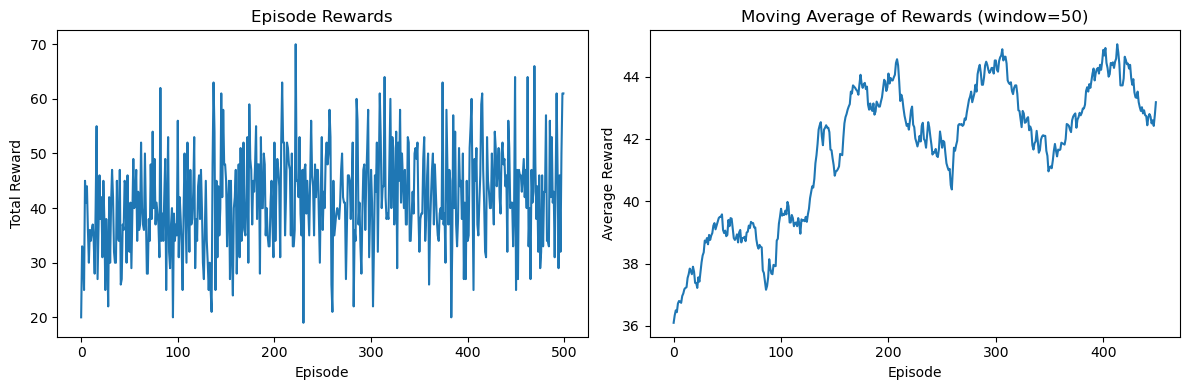

In [21]:
# Training and evaluation script
def main():
    # Create environment
    env = minimumGymEnv()
    
    # Create and train agent
    print("Training Q-Learning Agent...")
    agent = QLearningAgent(
        env, 
        learning_rate=0.1,
        discount_factor=0.9,
        exploration_rate=0.1
    )
    
    # Train the agent
    agent.train(num_episodes=500, max_steps=50, verbose=True)
    
    # Test the trained agent
    print("\nTesting trained agent...")
    test_rewards = agent.test(num_episodes=10, render=True)
    print(f"Average test reward: {np.mean(test_rewards):.2f}")
    
    # Display learned policy
    print("\nLearned Policy:")
    policy = agent.get_policy()
    action_names = {0: "GROW", 1: "DIVIDE", 2: "DORMANT"}
    
    for state in sorted(policy.keys()):
        action = policy[state]
        q_values = agent.Q[state]
        print(f"State {state}: {action_names[action]} (Q-values: {[f'{q:.2f}' for q in q_values]})")
    
    # Plot training progress
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(agent.episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    # Moving average of rewards
    window = 50
    moving_avg = [np.mean(agent.episode_rewards[i:i+window]) 
                 for i in range(len(agent.episode_rewards) - window)]
    plt.plot(moving_avg)
    plt.title(f'Moving Average of Rewards (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()